# AUTOENCODIX PACKAGE HANDBOOK
This notebook demonstrates the usage of the autoencodix package.
For now it serves as an internal guideline with the goal to:
- test the package from a user perspective
- serve as a first draft of user documentation
- serve a developer guideline 
  - developer guide will be derrived from this notebook

## 00 Generate mock data
We provide a variable for example data that can be imported easily. Later we show how to use your own data and what do keep in mind when doing so.

In [1]:
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())
# os.chdir(os.path.join(notebook_dir, ".."))

/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


In [2]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 01 General Pipeline Usage

In [3]:
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig, DataCase

data in nanremover: multi_sc:
  multi_sc: 1000 samples × 700 features
multi_sc in nanremover: {'multi_sc': MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'}
datapacke in _split_data_package: multi_sc:
  multi_sc: 1000 samples × 700 features
{1000}
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Epoch: 0, Loss: 31.61239516735077
Epoch: 1, Loss: 28.00365173816681
Epoch: 2, Loss: 24.79224383831024
Creating plots ...


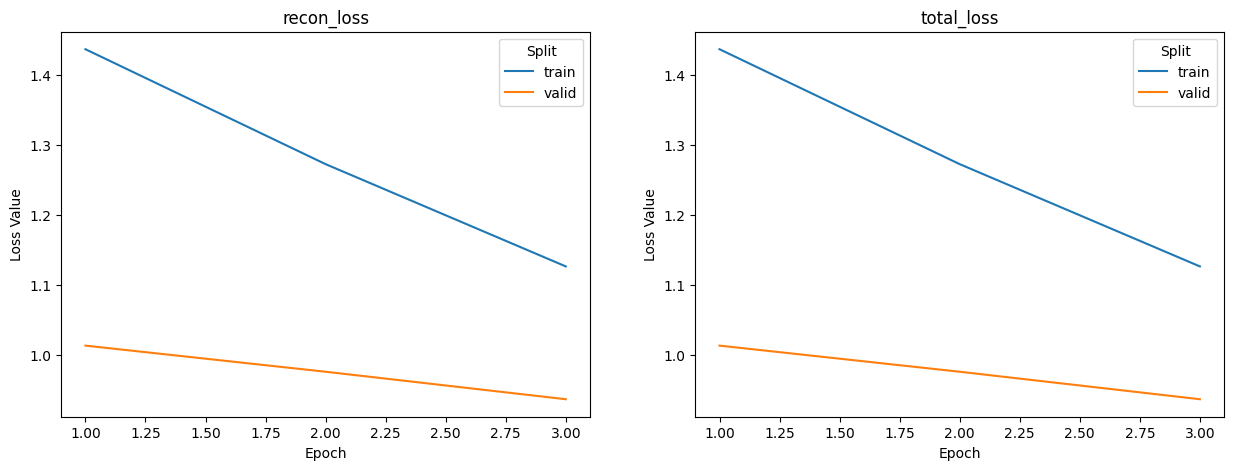

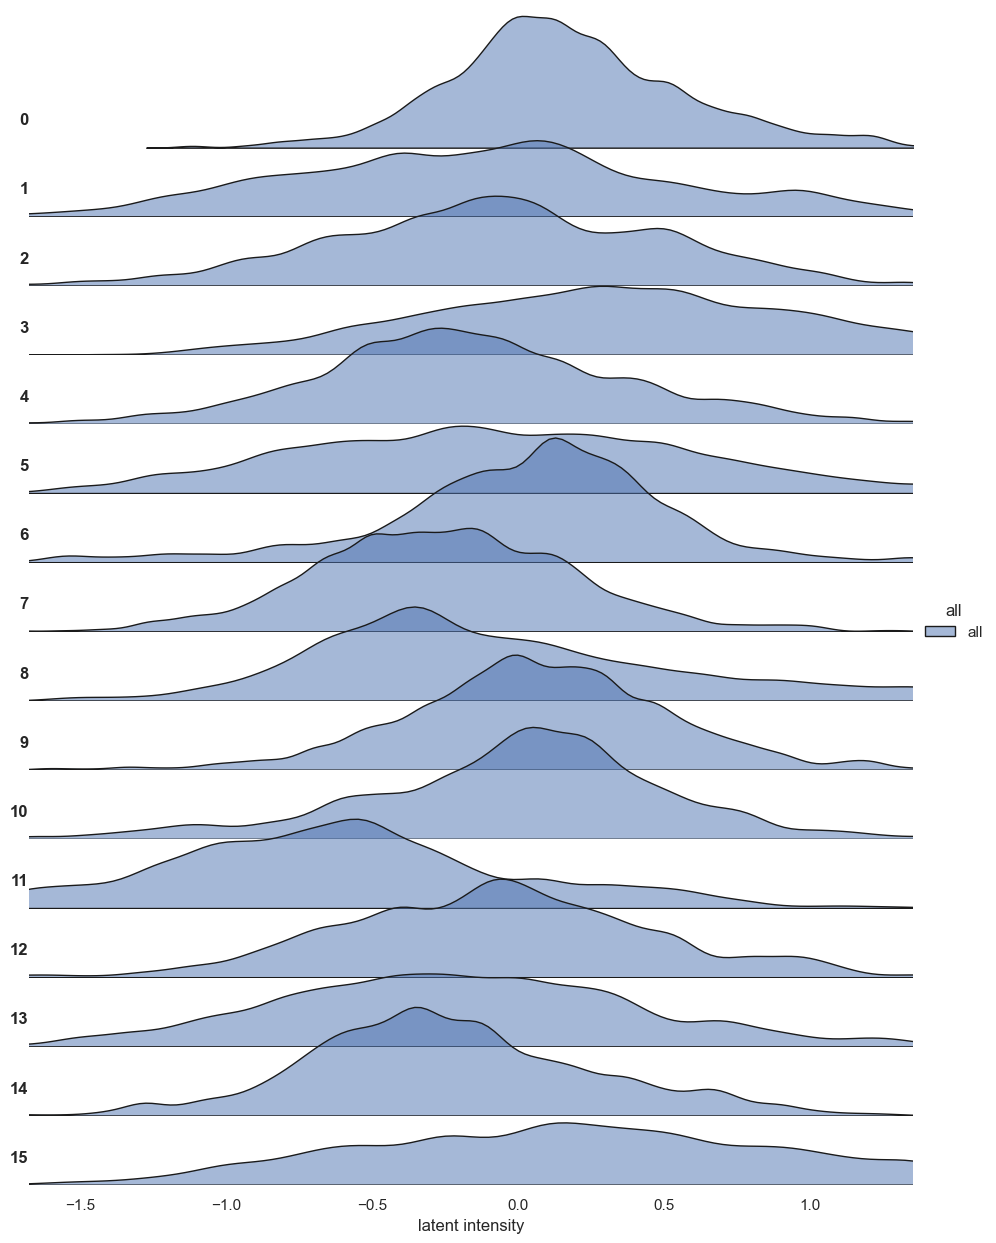

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


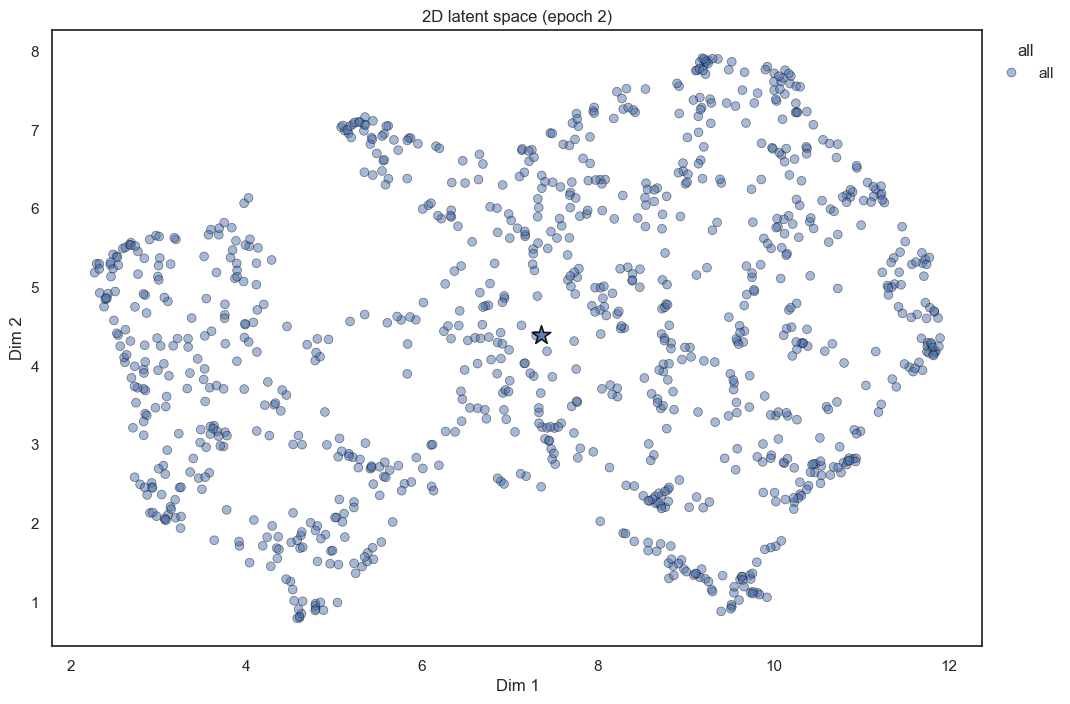

In [4]:
#### --------------------------------------------
### INITIALIZATION ### --------------------------
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL)
van = acx.Vanillix(user_data=raw_sc, config=config)
# ------------------------------------------------
### DATA PROCESSING ### --------------------------
# job of old make data
# populates self._datasets attribute with torch dataset
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# ------------------------------------------------
### MODEL TRAINING ### --------------------------
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (model, losses, etc)
van.fit()
# ------------------------------------------------
### PREDICTION ### -------------------------------
# job of old make predict
# if no data is passed, used the test split from preprocessing
# otherwise, uses the data passed, and preprocesses it
# updates self.result attribute with predictions (latent space, reconstructions, etc)
van.predict()
# ------------------------------------------------
### EVALUATION ### -------------------------------
# job of old make ml_task
# populates self.result attribute with ml task results
van.evaluate()  # not implemented yet
# ------------------------------------------------
### VISUALIZATION ### ---------------------------
# job of old make visualize
# populates self.result attribute with visualizations
van.visualize()
# show visualizations for notebook use
van.show_result()
# --------------------------
# --------------------------

In [67]:
van.result.final_reconstruction

multi_bulk:
  transcriptomics: 500 samples × 10 features
  proteomics: 500 samples × 10 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features

In [5]:
import torch

result = van.result
rec = result.reconstructions.get(split="test", epoch=-1)
print(rec.shape)

(200, 20)


In [6]:
processor = van._preprocessor
recon_package = processor.format_reconstruction(rec)

{700}
{100}
{200}


In [7]:
processor._dataset_container["test"].data.shape
print(recon_package.multi_sc)


# len(processor._reverse_mapping_multi_bulk["test"]["transcriptomics"][1]

{'multi_sc': MuData object with n_obs × n_vars = 200 × 20
  2 modalities
    rna:	200 x 10
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes', 'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
    protein:	200 x 10
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes', 'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'}


In [8]:
raw_bulk

multi_bulk:
  transcriptomics: 500 samples × 100 features
  proteomics: 500 samples × 80 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features

In [9]:
processor._datapackage_dict

{'train': {'data': multi_sc:
    multi_sc: 700 samples × 20 features,
  'indices': {'paired': {'train': array([795, 895, 451, 469, 732, 261, 947, 946, 632,  45,   5, 260, 298,
           157,  11, 984,  76, 762, 279, 567, 652, 297, 972, 601, 870, 596,
           312, 362, 739, 837, 954, 864, 445, 653, 624, 282, 619,  52, 737,
           819, 805, 178, 163, 782, 939, 112, 461, 777, 655, 448, 941,   1,
           432, 149,  85, 272, 588, 616, 760, 787, 908, 989, 382, 122, 136,
           900, 611, 750, 341, 129, 109, 197, 935, 434, 707, 405, 990, 815,
           289, 889, 217, 943, 749, 429, 991, 271, 878, 234, 286, 817, 859,
           909, 557, 869, 648, 583,  62, 336, 697,  22, 882, 846, 604, 861,
           912, 610, 256, 613, 980, 876, 468, 467, 801, 811, 224, 412, 726,
           401, 529, 277, 410, 172, 955, 174, 899, 703, 123, 287, 141, 645,
            58, 456,  93, 823,  54, 841,  74, 828, 183, 626, 435, 134, 177,
           418, 139, 978, 313, 804, 290, 333, 295, 105, 497, 385

In [10]:
print(len(van._preprocessor.sc_general_genes_to_keep["rna"]))
van.save(file_path="van.pkl")
van2 = acx.Vanillix.load("van.pkl")
print(len(van2._preprocessor.sc_general_genes_to_keep["rna"]))
# output: None


10
Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.
Attempting to load a pipeline from van.pkl...
Pipeline object loaded successfully. Actual type: Vanillix
Preprocessor loaded successfully.
Model state loaded successfully.
10


In [11]:
for split, split_data in processor._datapackage_dict.items():
    if split_data["data"] is None:
        print(f"Split {split} has no data.")
    print(split_data["data"])
#     if split_data["data"] is not None and len(split_data["data"]) == n_samples:
#         return split
# raise ValueError(
#     f"Cannot find matching split for {n_samples} samples in the dataset."
# )


multi_sc:
  multi_sc: 700 samples × 20 features
multi_sc:
  multi_sc: 100 samples × 20 features
multi_sc:
  multi_sc: 200 samples × 20 features


### Loading and Saving Data

In [12]:
van2.result.model == van.result.model
import torch

model1_state_dict = van.result.model.state_dict()
model2_state_dict = van2.result.model.state_dict()

In [13]:
van2.result.model

VanillixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=16, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=16, out_feature

In [14]:
import torch

recon = van.decode(latent=torch.zeros((10, 16)))
recon.shape

torch.Size([10, 20])

In [15]:
van.result.datasets.test.sample_ids

['cell_693',
 'cell_702',
 'cell_871',
 'cell_616',
 'cell_963',
 'cell_494',
 'cell_452',
 'cell_196',
 'cell_773',
 'cell_447',
 'cell_179',
 'cell_930',
 'cell_946',
 'cell_25',
 'cell_655',
 'cell_976',
 'cell_859',
 'cell_12',
 'cell_993',
 'cell_784',
 'cell_377',
 'cell_157',
 'cell_580',
 'cell_376',
 'cell_676',
 'cell_901',
 'cell_793',
 'cell_49',
 'cell_972',
 'cell_205',
 'cell_423',
 'cell_285',
 'cell_578',
 'cell_601',
 'cell_763',
 'cell_169',
 'cell_542',
 'cell_958',
 'cell_110',
 'cell_650',
 'cell_785',
 'cell_103',
 'cell_940',
 'cell_65',
 'cell_368',
 'cell_371',
 'cell_247',
 'cell_208',
 'cell_457',
 'cell_299',
 'cell_868',
 'cell_615',
 'cell_606',
 'cell_387',
 'cell_478',
 'cell_79',
 'cell_146',
 'cell_23',
 'cell_536',
 'cell_40',
 'cell_490',
 'cell_585',
 'cell_281',
 'cell_973',
 'cell_929',
 'cell_42',
 'cell_136',
 'cell_44',
 'cell_345',
 'cell_912',
 'cell_15',
 'cell_167',
 'cell_821',
 'cell_305',
 'cell_794',
 'cell_788',
 'cell_68',
 'cell_441

In [16]:
recon = van.decode(latent=van.result.adata_latent)
print(recon.shape)

(200, 20)


Or run all steps in one command

In [17]:
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL)
van = acx.Vanillix(user_data=raw_sc, config=config)

result = van.run()

data in nanremover: multi_sc:
  multi_sc: 1000 samples × 700 features
multi_sc in nanremover: {'multi_sc': View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'}
datapacke in _split_data_package: multi_sc:
  multi_sc: 1000 samples × 700 features
{1000}
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: i

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Epoch: 0, Loss: 31.79824733734131
Epoch: 1, Loss: 27.90347123146057
Epoch: 2, Loss: 25.20289397239685


In [18]:
recons = result.reconstructions.get(split="train", epoch=2)
recons_val = result.reconstructions.get(split="valid", epoch=2)
recons_test = result.reconstructions.get(split="test", epoch=-1)

print(f"Training reconstruction shape: {recons.shape} (samples x features)")
print(f"Validation reconstruction shape: {recons_val.shape} (samples x features)")
print(f"Test reconstruction shape: {recons_test.shape} (samples x features)")
print(
    f"Total reconstructed samples: {recons.shape[0] + recons_val.shape[0] + recons_test.shape[0]}"
)

Training reconstruction shape: (700, 20) (samples x features)
Validation reconstruction shape: (100, 20) (samples x features)
Test reconstruction shape: (200, 20) (samples x features)
Total reconstructed samples: 1000


In [19]:
latents = result.latentspaces.get(split="train", epoch=2)
latents_val = result.latentspaces.get(split="valid", epoch=2)
latents_test = result.latentspaces.get(split="test", epoch=-1)

print(
    f"Training latent representations: {latents.shape} (n_samples={latents.shape[0]}, latent_dim={latents.shape[1]})"
)
print(
    f"Validation latent representations: {latents_val.shape} (n_samples={latents_val.shape[0]}, latent_dim={latents_val.shape[1]})"
)
print(
    f"Test latent representations: {latents_test.shape} (n_samples={latents_test.shape[0]}, latent_dim={latents_test.shape[1]})"
)
print(
    f"Total encoded samples: {latents.shape[0] + latents_val.shape[0] + latents_test.shape[0]}"
)
print(f"Latent space dimensionality: {latents.shape[1]}")


Training latent representations: (700, 16) (n_samples=700, latent_dim=16)
Validation latent representations: (100, 16) (n_samples=100, latent_dim=16)
Test latent representations: (200, 16) (n_samples=200, latent_dim=16)
Total encoded samples: 1000
Latent space dimensionality: 16


#### Using a custom train, test, valid split
When you pass the data to the pipeline, autoencodix, internally splits the data for you based on the train,test, valid ratios provided in the config (defaults are 70%/10%/20% train/valid/test).
You can either pass custom ratios (see next section) or provide the indices directly as shown below

In [20]:
import numpy as np
from autoencodix.utils.default_config import DataCase

sample_data = np.random.rand(100, 10)
custom_train_indices = np.arange(75)  # we won't allow overlap between splits
custom_valid_indices = np.arange(75, 80)
custom_test_indices = np.arange(80, 100)

# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = acx.Vanillix(user_data=raw_bulk, custom_splits=custom_split, config=config)
van.preprocess()
van.fit(epochs=3)

datapacke in _split_data_package: multi_bulk:
  transcriptomics: 500 samples × 100 features
  proteomics: 500 samples × 80 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
{500}
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key:

It is possible to pass empty splits, but depending on how you'll use the autoencodix pipeline, this will throw an error at some point. So it is possible to call `fit` with only training data, but if you want to call `predict` and don't provide new data, this won't work without a data in the test split

#### Using predict with new data
The standard case is to train the model with the train data and then predict with the test split.
However, it is possible to pass new data to the predict method to perform inference on this data with the already trained model.

Here you have two options:
1. Provide a fully processed dataset (similiar to `EXAMPLE_PROCESSED_DATA`) See the section `Work with you own data` for details.
2. Provide raw data, which will be processed before predicting (also see `Work with your own data`)

You pass the data with the keyword argument `data`, and depending on the datatype, the pipeline knows whether to preprocess or not.

In [21]:
# assume new data
new_data = raw_bulk
van.predict(data=new_data)

genes_to_keep_map in _postsplit_multi_bulk before split loop: {'transcriptomics': ['gene_15', 'gene_20', 'gene_48', 'gene_42', 'gene_31', 'gene_57', 'gene_58', 'gene_14', 'gene_2', 'gene_24'], 'proteomics': ['protein_75', 'protein_36', 'protein_13', 'protein_62', 'protein_4', 'protein_30', 'protein_69', 'protein_9', 'protein_17', 'protein_0']} for datapackage_key: multi_bulk
datapackage_key in _postsplit_multi_bulk: multi_bulk
 keys in processed_package[datapackage_key]: dict_keys(['transcriptomics', 'proteomics'])
Applying STANDARD scaling.
shape before scaling: (500, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (500, 10)
scaler: StandardScaler()
{500}


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VanillixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x35531c5e0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3552ac2b0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x34f047070>)
new_datasets: DatasetContainer(train=None, valid=None, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x35526b370>)
adata_latent: AnnData object with n_obs × n_vars = 500 × 16
    uns: 'var_names'
final_reconstruction: multi_bulk:
  transcriptomics: 500 samples × 10 features
  proteomics: 500 sample

#### Examining the result of the pipeline
Each step in the pipeline writes its results in the result object of the Vanillix instance.
In this section we explore how to access and make sense of the results.

In [22]:
result = van.result
print(result)

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VanillixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x35531c5e0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3552ac2b0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x34f047070>)
new_datasets: DatasetContainer(train=None, valid=None, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x35526b370>)
adata_latent: AnnData object with n_obs × n_vars = 500 × 16
    uns: 'var_names'
final_reconstruction: multi_bulk:
  transcriptomics: 500 samples × 10 features
  proteomics: 500 sample

##### TrainingDynamics object in result
The training dynamics object has the followinf form:
<epoch><split><data>
So if you want to access the train loss for the 5th epoch, you would:
`result.lossss.get(epoch=5, split="train")`

##### The `.get()` Method Explained

The `reconstructions.get()` method provides flexible access to reconstruction data stored during training. It can retrieve data for specific epochs, specific splits, or any combination of these parameters.


##### Parameters:

- **`epoch`** (Optional[int]): 
  - Positive integer (e.g., `2`): Get reconstructions from that specific epoch
  - Negative integer (e.g., `-1`): Get the latest epoch (-1), second-to-last (-2), etc.
  - `None`: Return data for all epochs

- **`split`** (Optional[str]):
  - Valid values: "train", "valid", "test"
  - `None`: Return data for all splits

##### Return Value Behavior:

The method returns different types depending on the parameters:

1. **Both `epoch` and `split` specified**:
   - Returns a NumPy array for that specific epoch and split
   - Example: `get(epoch=2, split="train")` → `array([...])` 

2. **Only `epoch` specified**:
   - Returns a dictionary of all splits for that epoch
   - Example: `get(epoch=2)` → `{"train": array([...]), "valid": array([...]), ...}`

3. **Only `split` specified**:
   - Returns a NumPy array containing data for that split across all epochs
   - Example: `get(split="train")` → `array([[...], [...], ...])` (first dimension represents epochs)

4. **Neither specified**:
   - Returns the complete nested dictionary structure
   - Example: `get()` → `{0: {"train": array([...])}, 1: {...}, ...}`

##### Special Handling:

- If an invalid split is provided, a `KeyError` is raised
- Negative epoch indices work like Python list indexing (-1 is the last epoch)
- If an epoch doesn't exist, an empty array or dictionary is returned

##### Code Example:

In [23]:
loss_train_ep2 = result.losses.get(epoch=2, split="train")
print(loss_train_ep2)
valid_loss = result.losses.get(split="valid")
print(valid_loss)
print(result.losses.get())

1.2315019369125366
[0.94019529 0.95063257 0.94817024]
{0: {'train': array(1.45013221), 'valid': array(0.94019529)}, 1: {'train': array(1.35396304), 'valid': array(0.95063257)}, 2: {'train': array(1.23150194), 'valid': array(0.94817024)}}


In [24]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    # EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
# raw_sc = EXAMPLE_MULTI_SC

Note: this schema works for every TrainingDynamics instance in the results object.

## 02 Pipeline usage with custom parameters
Here we show how to customize the above shown pipeline with a user config or with keyword arguments.
Alternatively, we can read the config parameters from a YAML file.

In [25]:
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
van = acx.Vanillix(user_data=processed_data)
# job of old make data
# populates self._features attrbute with torch tensor
# populates self._datasets attribute with torch dataset
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (losses, etc)
# van.fit()
""" 
Each step can be run separately, with custom parameters, these parameters
can be passed as keyword arguments, or as a Config object
"""
van.fit(learning_rate=0.01, batch_size=32, epochs=5)  # or like this:
my_config = DefaultConfig(learning_rate=130.0, batch_size=32, epochs=5)
van.fit(config=my_config)  # config has to be an keyword argument

cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359
cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359


#### 02.1  How to relevant keyword arguments for pipeline methods
It can be hard to know what keyword arguments are valid for each step,
so we show:
- how to get a list of allowed keyword arguments
- what happens if you pass non-allowed keyword arguments

In [26]:
import pprint

# for each config method, we can call a valid_params method
van = acx.Vanillix(user_data=processed_data)

# returns a set of keyword arguments that are actually used in the fit method
fit_params = van.fit.valid_params

pprint.pprint(fit_params)

{'batch_size',
 'checkpoint_interval',
 'config',
 'device',
 'epochs',
 'global_seed',
 'gpu_strategy',
 'learning_rate',
 'n_gpus',
 'n_workers',
 'reconstruction_loss',
 'reproducible',
 'weight_decay'}


To get even more verbose info about the keyword args, you can run the following code.

In [27]:
# when you want to have more info about the params, you can get type hints from the config object
my_config = DefaultConfig()
conig_values = my_config.get_params()
my_config.print_schema(filter_params=fit_params)

Valid Keyword Arguments:
--------------------------------------------------

learning_rate:
  Type: <class 'float'>
  Default: 0.001
  Description: Learning rate for optimization

batch_size:
  Type: <class 'int'>
  Default: 32
  Description: Number of samples per batch

epochs:
  Type: <class 'int'>
  Default: 3
  Description: Number of training epochs

weight_decay:
  Type: <class 'float'>
  Default: 0.01
  Description: L2 regularization factor

reconstruction_loss:
  Type: typing.Literal['mse', 'bce']
  Default: mse
  Description: Type of reconstruction loss

device:
  Type: typing.Literal['cpu', 'cuda', 'gpu', 'tpu', 'mps', 'auto']
  Default: auto
  Description: Device to use

n_gpus:
  Type: <class 'int'>
  Default: 1
  Description: Number of GPUs to use

n_workers:
  Type: <class 'int'>
  Default: 2
  Description: Number of data loading workers

checkpoint_interval:
  Type: <class 'int'>
  Default: 1
  Description: Interval for saving checkpoints

gpu_strategy:
  Type: typing.Lit

If you pass not supported parameters you get a warning and we fall back to default values.

In [28]:
# if you use an unsupported keyword argument, you will get a warning
# as you see the default value from the DefaultConfig is not overwritten and the training will take 100 epochs (not 10)
van.preprocess()
van.fit(epochds=10)


Invalid config parameters: epochds
Valid config parameters are: batch_size, checkpoint_interval, config, device, epochs, global_seed, gpu_strategy, learning_rate, n_gpus, n_workers, reconstruction_loss, reproducible, weight_decay
These parameters will be ignored.
cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359


#### 02.2 How to get information about the default config parameters

In [29]:
# if you want to see what config parameters are used in the default config you can do it like:
default_config = DefaultConfig()
default_config.print_schema()


DefaultConfig Configuration Parameters:
--------------------------------------------------

data_config:
  Type: <class 'autoencodix.utils.default_config.DataConfig'>
  Default: data_info={} require_common_cells=False annotation_columns=None
  Description: No description available

paired_translation:
  Type: typing.Optional[bool]
  Default: PydanticUndefined
  Description: Indicator if the samples for the xmodalix are paired, based on some sample id

data_case:
  Type: typing.Optional[autoencodix.utils.default_config.DataCase]
  Default: PydanticUndefined
  Description: Data case for the model, will be determined automatically

k_filter:
  Type: typing.Optional[int]
  Default: 20
  Description: Number of features to keep

skip_preprocessing:
  Type: <class 'bool'>
  Default: False
  Description: If set don't scale, filter or clean the input data.

latent_dim:
  Type: <class 'int'>
  Default: 16
  Description: Dimension of the latent space

n_layers:
  Type: <class 'int'>
  Default: 3

### 02.3 Documentation Config class
You can update the config with your own values by:
- passing arguments as:
    - dict
    - single arguments
- passing a file (sample configs and data can be found [here](https://cloud.scadsai.uni-leipzig.de/index.php/s/54aL6E6QebHDXPy)).

In [30]:
from autoencodix.utils.default_config import DefaultConfig
import yaml
from pathlib import Path

# METHOD 1: override the default config with a dictionary
my_args = {"learning_rate": 0.0234, "batch_size": 13, "epochs": 12}
my_config = DefaultConfig(**my_args)
# METHOD 2: override signle parameters
my_new_conig = DefaultConfig(latent_dim=23, n_gpus=13)

# METHOD 3: from a file:
custom_config = DefaultConfig.model_validate(
    {
        **yaml.safe_load(Path("configs/multi_bulk.yaml").read_text()),
        "learning_rate": 0.77,
    }
)

## 03 Use the Varix model
Now we show how easy it is to use a variational autoencoder instead of a vanilla version.

In [31]:
from autoencodix.utils.default_config import DefaultConfig
from autoencodix.utils.default_config import DataCase
import autoencodix as acx

my_config = DefaultConfig(learning_rate=0.001, epochs=3, checkpoint_interval=1)
my_config.data_case = DataCase.MULTI_BULK
van = acx.Varix(user_data=processed_data, config=my_config)
result = van.run()

cpu not relevant here
[30, 16, 16, 16, 16]
Epoch: 0, Loss: 896.4594078063965
Epoch: 1, Loss: 883.8003387451172
Epoch: 2, Loss: 869.7563400268555


In [32]:
print(result.datasets.train.feature_ids)
print(my_config.data_case)

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29']
DataCase.MULTI_BULK


#### Examine Variational result
Here, we have more info in our results object than in the Vanillix case. We have the learned paramters mu and logvar of the normal distirbution, in addition to the losses and reconstructions. We provide also the sampled latentspaces at each epoch and split.

You can resample new latenspaces (shown in next section)

In [33]:
# we did not train for the test split, so we don't need to pass an epoch
# technically the epoch is -1
mu_test_ep_last = result.latentspaces.get(split="test")
print(mu_test_ep_last.shape)

(1, 201, 16)


#### Different loss types
For our variation autoencoder, the total loss consists of a reconstruction loss and a distribution loss i.e. kl-divergence. To investigate these losses, the result_obj has the attribute `sub_losses`. This is a `LossRegistry` withe the name of the loss as key and the value is of class `TrainingDynamics` and can be accessed as shown for the Vanillix part

In [34]:
sub_losses = result.sub_losses
print(f"keys: {sub_losses.keys()}")
recon_dyn = sub_losses.get(key="recon_loss")
print(recon_dyn.get(split="train"))

keys: dict_keys(['recon_loss', 'var_loss'])
[40.71245367 40.13542921 39.49522296]


#### Sample new latentspaces
You might want to use the trained model and the fitted parameters mu, and logvar to sample latentspaces. Therefore, the Varix pipeline has the additional method `sample_latent_space`

In [35]:
sampled = van.sample_latent_space()

print(sampled[:5])

tensor([[-0.3815,  0.0605,  0.0737, -0.5899,  0.9586, -0.5613,  0.6648,  0.6568,
          0.5968,  2.1347, -1.2397, -1.3647, -0.8332,  1.4871, -1.2338, -0.2871],
        [-0.8745, -1.8087, -1.1001, -2.1044, -0.4924,  0.0313, -1.0118,  1.0175,
         -0.9504,  1.5237,  1.4555,  0.6733, -0.3959,  1.3795, -2.0161,  1.1900],
        [ 1.1961, -0.4509,  0.0881,  0.0250, -0.7878,  0.3866, -0.5984,  1.3542,
          0.5217, -0.9234,  0.0960, -0.1184,  3.1499,  0.0853, -1.4222,  1.2531],
        [ 0.0435,  1.8601,  2.3153,  0.8313,  1.7955, -0.2479, -1.0111,  0.3796,
          1.6390,  0.9053, -0.9798,  1.2234,  0.3115, -0.5283,  2.2437, -1.6342],
        [ 0.9065,  0.7891, -0.6991,  0.8421, -0.9909, -0.9001,  1.1103, -0.8292,
         -1.2215, -0.4107, -0.5272, -0.3176,  1.5901,  1.7986, -0.0936,  1.4206]],
       device='mps:0')


In [36]:
# you can also select a specific epoch and split to sample from (default is last epoch and test split)
sampled = van.sample_latent_space(epoch=2, split="valid")
print(sampled[:5])

tensor([[ 0.5700,  0.8758,  0.9141, -0.6604,  1.0592, -0.4484,  1.9340,  0.8800,
          0.1392,  1.5425,  1.1866,  1.1662,  0.7115,  0.0068,  3.0569,  0.4558],
        [ 0.2120,  0.9299, -1.6927,  1.0529,  2.0094, -1.5707, -0.1146, -0.8113,
          0.4337,  1.3734,  0.0598,  4.8622,  2.5011,  2.2839,  0.2209,  1.0999],
        [ 1.3187,  2.6637,  1.3148, -0.8652, -2.2424,  2.1532,  0.5025,  2.2731,
          0.2291,  0.1469,  1.2588,  0.0867,  0.8309, -0.2264, -0.9445,  0.0722],
        [-0.9690,  2.0278, -0.8018, -0.8929,  0.9704,  0.5589,  1.1102,  2.9140,
          0.7758,  1.0506,  1.0099, -0.6375, -1.2596,  1.4819,  0.6696,  1.2880],
        [ 0.3513, -0.4607, -1.4169, -0.3616,  0.5239, -0.1536, -2.5674,  0.4172,
          1.4041,  1.1064, -0.2263,  1.1523, -0.2858,  1.2119, -1.6832, -0.7073]],
       device='mps:0')


In [37]:
# or sample multiple times
for _ in range(5):
    sampled = van.sample_latent_space()
    print(sampled[:3, :3])

tensor([[-2.1316,  0.8674,  1.0452],
        [ 0.9337,  0.0566,  0.4687],
        [ 1.0547, -0.8719,  0.1045]], device='mps:0')
tensor([[ 0.4005,  0.2328,  0.7930],
        [ 0.3041,  0.0535, -0.4952],
        [-0.4317,  0.3115, -1.7468]], device='mps:0')
tensor([[ 2.1802, -1.3408,  0.7844],
        [ 0.2504, -0.8375, -0.5194],
        [ 1.3116,  0.4400, -1.6655]], device='mps:0')
tensor([[ 1.8349,  1.8234, -0.7378],
        [ 2.4539,  1.4715,  2.5609],
        [ 1.8668,  1.6702,  0.3699]], device='mps:0')
tensor([[ 0.2679, -0.9179,  0.5593],
        [-0.2163, -0.2724,  1.6587],
        [ 1.4239, -0.3327, -1.4850]], device='mps:0')


## 04 Work with your own data
In the above steps we showed how to use `Autoencodix` with mock data. Nowe we demonstrate how to use real-world data. There are three main use cases:
1. Use data from raw files and define the path and metainfo via the config (file or DefaultConfig class).
2. Provide the raw data directly in Python and pass it to our `DataPackage` structure. This `DataPackage` then can be passed to to our Pipeline where it will pre preprocessed.
3. Take care of the preprocessing yourself and pass the `DatasetContainer` to our pipeline. We show how to fill this `DatasetContainer` object with your preprocsedded data.

### 04.1 Working with data from files
Here we specialize on different kind of omics data. We cover:
1. combining multi-omics data from bulk sequencing (e.g. mRNA and methylation).
2. combining multi-omics data from single cell sequencing.
3. "Translating" between multi-omics data e.g. scRNA <-> scATAC, or bulkmRNA <-> bulkmiRNA
4. Working with image data
5. "translating" between data-modalities
  - one bulk-omics modality to another
  - omics to image an vice versa

#### 04.1.1 Combining mulit-omics data from bulk-sequencing
First we need to prepare our config object. We can (a) directly provide an object in python, or (b) provide an YAML file. We show both

##### YAML config
Assume we have the file in `./config.yaml`.
We can keep the yaml file structure to define our input data like:
```yaml
data_config: # has to be named data_config
  data_info: # has to be named data_infor
   RNA: # name can be chosen by user
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   METHYLATION: # can be chosen by user
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   CLINICAL: # can be chosen by user
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION" # default NUMERIC (as for RNA and METHYLATION)
```
ATTENTION:
If you use `.txt` or `.csv` files, it is best practice to add the `sep` parameter. If none is given, the reader will try to auto-detect the separator, which is error prone.
This would loke like:
```YAML
    RNA:
      ...
      sep: "\t" # for tab, ";" or "," would be also possible (as in pandas)

```
**IMPORTANT**

For all your bulk data files, we expect the first column to be some kind of unique sample id. Please prepare the data accordingly.

In [38]:
import yaml
from pathlib import Path
from autoencodix.utils.default_config import DefaultConfig
import os

print(os.getcwd())
# this fills the data_config attribute of the DefaultConfig object
# we can also change the default values in the config.yaml file
# or via the DefaultConfig object
bulk_config = DefaultConfig.model_validate(
    yaml.safe_load(Path("configs/multi_bulk.yaml").read_text())
)
# this bulk_config object can then be passed to a Pipeline (Varix, Vanillix, etc)
var_bulk = acx.Varix(config=bulk_config)

/Users/maximilianjoas/development/autoencodix_package


In [39]:
result = var_bulk.run()

datapacke in _split_data_package: multi_bulk:
  RNA: 10 samples × 16313 features
  METHYLATION: 10 samples × 9228 features
annotation:
  paired: 10 samples × 54 features
{10}
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute

We can also overwrite or add values to our config from the config file.

In [40]:
# with custom values
custom_config = DefaultConfig.model_validate(
    {
        **yaml.safe_load(Path("configs/multi_bulk.yaml").read_text()),
        "learning_rate": 0.77,
    }
)

##### Create DataConfig in Python
Instead of reading the config from the file, we can also create it directly in Ptyon
We will only use one way of config creation for the next examples.

In [41]:
from autoencodix.utils.default_config import DataConfig, DataInfo

root_dir = os.path.join("data/raw")
meth_file = "data_methylation_per_gene_formatted.parquet"
mrna_file = "data_mrna_seq_v2_rsem_formatted.parquet"
clin_file = "data_clinical_formatted.parquet"

bulk_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "RNA": DataInfo(file_path=os.path.join(root_dir, mrna_file)),
            "METHYLATION": DataInfo(file_path=os.path.join(root_dir, meth_file)),
            "CLINICAL": DataInfo(
                file_path=os.path.join(root_dir, clin_file), data_type="ANNOTATION"
            ),
        }
    )
)
#

#### 04.1.2 Working with single cell data from different sequencing processes
First we define our config again, then we use the reader object to build the MuData object (this will look more familar for single cell practioners)

We can provide a config yaml like:
```yaml
# config.yaml
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad" # we request h5ad files
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
```

In [42]:
from autoencodix.utils import DefaultConfig
import yaml
from pathlib import Path

scconfig = DefaultConfig.model_validate(
    yaml.safe_load(Path("configs/largesc.yaml").read_text())
)

In [43]:
import autoencodix as acx

sc_van = acx.Vanillix(config=scconfig)

sc_van.preprocess()
# result = sc_van.run()

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4554
data in nanremover: multi_sc:
  multi_sc: 4554 samples × 18018 features
multi_sc in nanremover: {'multi_sc': View of MuData object with n_obs × n_vars = 4554 × 18018
  2 modalities
    RNA:	4554 x 9009
      obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
      uns:	'batch_condition', 'citat

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:67: ImplicitModificationWarning: Setting element `.layers['log2_X']` of view, initializing view as actual.
  adata.layers[layer_name] = layer_matrix[layer_valid_rows, :][
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:67: ImplicitModificationWarning: Setting element `.layers['log_X']` of view, initializing view as actual.
  adata.layers[layer_name] = layer_matrix[layer_valid_rows, :][
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


datapacke in _split_data_package: multi_sc:
  multi_sc: 4554 samples × 18018 features
{4554}
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: 

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying VAR filtering
Shape after filtering: (3187, 10)
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Applying VAR filtering
Shape after filtering: (3187, 10)
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Apply

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [44]:
sc_van.fit(device="cpu", epochs=1)

cpu not relevant here
Epoch: 0, Loss: 105.61258375644684
Epoch: 1, Loss: 84.90604948997498
Epoch: 2, Loss: 72.59502393007278


In [45]:
import scanpy as sc

filepath = "data/raw/Sc-2-mini.h5ad"
adata = sc.read(filepath)
print(adata)

AnnData object with n_obs × n_vars = 4554 × 9009
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_joint_wnn_umap', 'X_umap'
    layers: 'log2_X', 'log_X'


In [46]:
sc_van._datasets.test.data.size()

torch.Size([911, 50])

In [47]:
sc_van._datasets.train.data.size()

torch.Size([3187, 50])

Again, we can pass the `scconfig` to our Pipeline as shown with the bulk example.

#### 04.1.3 Translating between omics data
We only allow bulk to bulk and single-cell to single cell. The config is almost identical to the case before, we only add the direction of the translation like:
```YAML
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad"
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
     translate_direction: "FROM"
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
     translate_direction: "TO"

```

For the bulk case we can keep annotation data without including it in the translation like:
```YAML
# config.yaml
data_config:
  data_info:
   RNA:
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false
     translate_direction: "FROM"
   METHYLATION:
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false
     translate_direction: "TO"
   CLINICAL:
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION"
     # default translate_direction is  NONE, so we don't need to specify it here
```

#### 04.1.4 Working with images
When working with images, we need have two cases:
- pure image, without translating
- translating between omics and images

In the first case we need to provide the folder path of the images. In the second case we need to provide the folder path of the images and an annotation file that maps the metadata for the images to the image filenames. In this file we also need to map the sample_ids of the other data modality to the image filename and metadata. Later we will add support for an unpaired case, where we only provide image metadata without mapping to the other data modality.
The file should look like this:
**important**: this file needs to contain the columns `sample_ids` and `img_paths`
```text
sample_ids	img_paths	METADATA1	METADATA2
TCGA-05-4244-01	0_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4249-01	1_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4250-01	2_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4382-01	3_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4384-01	4_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4389-01	5_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4390-01	6_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4395-01	7_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4396-01	8_label_1.png	Non-Small Cell Lung Cancer	LUAD
```

##### Image only case

In [48]:
from autoencodix.utils.default_config import DataConfig, DataInfo

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(file_path="data/raw/images/tcga_fake", data_type="IMG"),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt", data_type="ANNOTATION"
            ),
        }
    )
)

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/default_config.py:393: UserWarning: Could not determine data_case: No numeric datasets found in data_info
  warnings.warn(f"Could not determine data_case: {str(e)}")


##### Images and omics data
If you want to translate between image and another data modality you need to provide the same files as above. For the Annotation files you have two possibilities: (a) you provide one annotation file (as shown above), in this file you match the metadata of the two data modalites, by an shared sample_id / mapping of sample_id and image_path and other metadata. (b) you can have supply an extra annotation file for the images with the attribute `img_anno_file`. If None is given, we will use the shared file. This is only allowed for unpaired translation.
So for the unpaired translation the `DataConfig` should look like:

In [49]:
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake",
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt",
                data_type="ANNOTATION",
            ),
        }
    )
)

In [50]:
from autoencodix.utils._imgreader import ImageDataReader

imgreader = ImageDataReader()
imgdata = imgreader.read_data(config=img_config)

reading annotation file: data/raw/tcga_mappings.txt


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:192: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


In [51]:
print(imgdata.keys())
print(f"Number of images: {len(imgdata['IMG'])}")

dict_keys(['IMG'])
Number of images: 3204


##### Unpaired case
This case is not implemented in the old version of `autoencodix` and will be added after the other translating features, we still show how the config can look like:
```python
from autoencodix.utils.default_config import DataConfig, DataInfo
img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake.txt",
                data_type="IMG",
                translate_direction="to"
                extra_anno_file="path/to/file"
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from"
            ),
            "ANNO": DataInfo(
                file_path="data_clinical_formatted.parquet",
                data_type="ANNOTATION",
            ),
        }
    )
)


#### 04.1 How to use raw data 
If you don't want to provide files via config, you can create a DataPackage directly in Python. First you need to decide what kind of data you use. We currently support the following cases:
- Multi-Bulk (or any other numeric data)
- Multi-SingleCell (or standard Single Cell)
- Bulk-to-Bulk translation
- SingleCell-to-SingleCell translation
- Image-Bulk translation or vice versa
- SingleCell-Image translation or vice versa

With Multi-Bulk (Multi-Numeric) we mean combining different types of  sequencing data e.g. mRNA and ATAC. We define Multi-Single-Cell analogous. 
Now we show how to prepare the data in Python. While we will perform basic preprocessing like NaN removal, and scaling and filtering (if specified), we expect a certain amount of preprocessing for omics data:
**For Bulk**:
- TODO
- TODO

**For Single Cell**
- TODO 
- TODO

##### Multi-Bulk / Multi-Numeric

In [52]:
import numpy as np
import pandas as pd
from autoencodix.data.datapackage import DataPackage
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataInfo,
    DataConfig,
    DataCase,
)
from autoencodix.vanillix import Vanillix

# Create fake methylation data
# you would normally load your data here
meth_data = pd.DataFrame(
    np.random.rand(100, 50),  # 100 samples, 50 features
    index=[f"Sample_{i}" for i in range(100)],
    columns=[f"Meth_Feature_{j}" for j in range(50)],
)

# Create fake RNA data
# you would normally load your data here
rna_data = pd.DataFrame(
    np.random.rand(100, 100),  # TODO align
    index=[f"Sample_{i}" for i in range(100)],
    columns=[f"RNA_Feature_{j}" for j in range(100)],
)

# Create fake clinical annotations
# you would normally load your data here
clinical_annotations = pd.DataFrame(
    {
        "Sample_ID": [f"Sample_{i}" for i in range(100)],
        "Age": np.random.randint(20, 80, size=100),
        "Gender": np.random.choice(["Male", "Female"], size=100),
        "Disease_Status": np.random.choice(["Healthy", "Diseased"], size=100),
    }
).set_index("Sample_ID")

# multi_bulk is a dict with "name/identifier" of the dataset as key
# the key for annotation needs to be "paired" if only one annotation is given, otherwise it has to have the same keys as multi_bulk
my_data = DataPackage(
    multi_bulk={"RNA": rna_data, "METH": meth_data},
    annotation={"paired": clinical_annotations},
)


Now you can pass this data to our Autoencodix. 

**IMPORTANT**: In you config you need specify the usecase (see code) 
The preprocessing will be done according to the values in the DefaultConfig. We show how to adjust this:

In [53]:
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = Vanillix(config=config, user_data=my_data)
# USE ONE OF THESE FOR data_case
for case in DataCase:
    print(case.name, case.value)

MULTI_SINGLE_CELL Multi Single Cell
MULTI_BULK Multi Bulk
BULK_TO_BULK Bulk<->Bulk
IMG_TO_BULK IMG<->Bulk
SINGLE_CELL_TO_SINGLE_CELL Single Cell<->Single Cell
SINGLE_CELL_TO_IMG Single Cell<->IMG
IMG_TO_IMG IMG<->IMG


In [54]:
van.preprocess()

datapacke in _split_data_package: multi_bulk:
  RNA: 100 samples × 100 features
  METH: 100 samples × 50 features
annotation:
  paired: 100 samples × 3 features
{100}
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: t

In [55]:
processed_data = van.result.datasets
print(processed_data)

DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3420d58a0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3549c8b80>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3549cb2b0>)


##### Multi-Single-Cell case
Here you can provide one MuData object an don't need an extra annotation file, because the annotation info is stored in `obs` of the modality.

In [56]:
import mudata

from autoencodix.data.datapackage import DataPackage
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse

# IMPORTANT specify datacase
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL)
# Number of samples and features
n_samples = 100
n_rna_features = 200
n_atac_features = 50

# Create sparse matrices instead of dense arrays
rna_X = sparse.csr_matrix(np.random.rand(n_samples, n_rna_features))
atac_X = sparse.csr_matrix(np.random.rand(n_samples, n_atac_features))

# Create observation and variable DataFrames
obs_df = pd.DataFrame(index=[f"Sample_{i}" for i in range(n_samples)])
rna_var_df = pd.DataFrame(index=[f"Gene_{i}" for i in range(n_rna_features)])
atac_var_df = pd.DataFrame(index=[f"ATAC_Feature_{i}" for i in range(n_atac_features)])

# Try creating AnnData objects with sparse matrices
rna_adata = ad.AnnData(X=rna_X, obs=obs_df, var=rna_var_df, dtype=np.float32)

atac_adata = ad.AnnData(
    X=atac_X,
    obs=obs_df,
    var=atac_var_df,
    dtype=np.float32,
)

# Create MuData object
mdata = mudata.MuData({"RNA": rna_adata, "ATAC": atac_adata})

dp = DataPackage(multi_sc={"multi_sc": mdata})
# Print the object
print(dp)

multi_sc:
  multi_sc: 100 samples × 250 features


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [57]:
from autoencodix import Varix

van = Varix(user_data=dp, config=config)
van.preprocess()

data in nanremover: multi_sc:
  multi_sc: 100 samples × 250 features
multi_sc in nanremover: {'multi_sc': MuData object with n_obs × n_vars = 100 × 250
  2 modalities
    RNA:	100 x 200
    ATAC:	100 x 50}
datapacke in _split_data_package: multi_sc:
  multi_sc: 100 samples × 250 features
{100}
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_mo

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


##### Translation between modalities.
If you want to translate between modalties i.e. mRNA to ATAC, you can populate the `from_modality` and `to_modality` attributes of the DataPackage. For the `annotation` attribute you need to add at leas one annotation file for the bulk/numeric case. Details see code:

As of March 2025, we've not implemented models that support Translation in the new package, so we only show how to prepare the data.

In [58]:
from autoencodix.data.datapackage import DataPackage
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataInfo,
    DataConfig,
    DataCase,
)
from autoencodix.vanillix import Vanillix

dp = DataPackage()
data_info = {
    "RNA": DataInfo(translate_direction="from"),
    "METH": DataInfo(translate_direction="to"),
}
config = DefaultConfig(
    paired_translation=True,  # we want to have matched samples in this case
    data_case=DataCase.BULK_TO_BULK,
    data_config=DataConfig(data_info=data_info),
)

dp.from_modality = {"from_modality": rna_data}
dp.to_modality = {"to_modality": meth_data}
dp.annotation = {
    "paired": clinical_annotations
}  # here we can also provide {RNA: rna_anno, MEth: meth_anno} if we have two anno files

van = Vanillix(user_data=dp, config=config)
van.preprocess()
datasets = van.result.datasets


datapacke in _split_data_package: annotation:
  paired: 100 samples × 3 features
from_modality:
  from_modality: 100 samples × 100 features
to_modality:
  to_modality: 100 samples × 50 features
{100}
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: mu

NotImplementedError: GeneralPreprocessor only handles multi_bulk or multi_sc.

In [ ]:
dp

##### Working with Images
When you want to use images for our pipelines, it is the easiest to pass the folder and annotations files via config params as shown above. For some usecases, however users want to. Therefore you need create a list of ImgData objects and pass them to the DataPackage.img attribute

In [ ]:
from autoencodix.data._imgdataclass import ImgData
from autoencodix.data.datapackage import DataPackage
import numpy as np

imgdata = [ImgData(img=np.array(1), sample_id="myImg", annotation=pd.DataFrame())]
dp = DataPackage({"IMG": imgdata})
# in real applications this will be a longer list of images
# you probably also would add other data modalites to the datapackge

#### 04.3 Working with Processed data
If you do all your processing yourself, you can just pass the torch tensor and metadata to our `DatasetContainer` data structure. The  DatasetContainer hold a dataset for each split (train, test, valid). This will skip our internal preprocessing. Here you need to know which Dataset (Pytorch Dataset child), you need for which Autoencodix. For now we only support Varix and Vanillix, which uses the class `NumericDataset`.

In [ ]:
from autoencodix.data._numeric_dataset import NumericDataset
from autoencodix.data._datasetcontainer import DatasetContainer
from autoencodix.utils.default_config import DefaultConfig
from autoencodix import Varix
import pandas as pd
import torch

container = DatasetContainer()
# fill the attributes with your data
ds = NumericDataset(
    data=torch.tensor(1), config=DefaultConfig(), sample_ids=[], metadata=pd.DataFrame()
)
container.train = ds
container.valid = ds  # your valid data

# if you want to run the predict step, you need to also fill the test attribute of
container.test = ds  # your test data

# now you can just pass the container as user data
van = Varix(user_data=container)
# valls var.run()


In [ ]:
# TODO add example (see already existing configs)

## 05 How to add a new architecture
### High level workflow
To add a new autoencoder architecture, you need to at least code two things:
- the model architecture itself in  `src/autoencodix/modeling/` - anlogous to `_varix_architecture.py`
- the pipeline itself in `src/autoencodix/` - analgous to `varix.py`
Depending on the complexity and data requirements you might also want to provide the following:
- a new custom dataset class in `src/autoencodix/data` - analogous to `numeric_dataset.py`
- a new custom preprocessor in `src/autoencodix/data` - as in `preprocessor.py`
- a new custom trainer in `src/autoencodix/trainers` - as in `_general_trainer.py`
  - including a custom predict method of your trainer
- a custom loss for your model
- a custom visualizer (no example implemented yet)
- a custom evaluator for downstream tasks (no example implemented yet)
- a custom tuner (not sure if this will be part of the package)
### High level structure
- Each autoencodix model in our family is based on our base classes in `src/autoencodix/base`. Here we have (often abstract) classes that define the general structure of each step (preprocess, fit, predict, evaluate, visualize) in our pipeline, as well as additional classes e.g. losses.
- In these base classes we've implemented shared functionalities, like calling the corresponding trainer, or preprocessor.
- The base classes also guide you to the structure of your new class. The methods of the base classes should not be changed. Rather overwrite the method in the implementation of your child class in case you need to make changes.

### Must-do files details
We'll illustrate this by an example. We want to add the new architecture with the name MySpecial to our package. First we add the actual architecture:
- create the file `src/autoencodix/modeling/_myspecialix_architecture.py` (note files that should not be imported at end-user lever have a leading underscore).
- for each newly created file, add the classes to the `__init__.py` in the corresponding folder. Example for the pipeline file in  `src/autoencodix`:
```python
from importlib.metadata import version, PackageNotFoundError

try:
    __version__ = version("autoencodix")
except PackageNotFoundError:
    __version__ = "unknown"

# Import key classes to make them directly accessible
from .vanillix import Vanillix
from .varix import Varix
from .stackix import Stackix
# NEW: -------------------------------------
from .MyNewSpecialix imiport MyNewSpecialix
# -----------------------------------------

__all__ = ["Vanillix", "Varix", "Stackix"] # TODO add "MyNewSpecialx"
```

- create the file `tests/test_modelling/test_myspecialix_architecture`
- we write the class itself that might look like:
```python
from autoencodix.base._base_autoencoder import BaseAutoencoder
# your imports
# TODO


# needs to inherit from BaseAutoencoder
class MySpecialArchitecture(BaseAutoencoder):
    """
    MySpecial implementation accroding to (cite paper, yourself, etc)

    Attributes
    ----------
    self.input_dim : int
        number of input features
    self.config: DefaultConfig
        Configuration object containing model architecture parameters
    self._encoder: nn.Module
        Encoder network of the autoencoder
    self._decoder: nn.Module
        Decoder network of the autoencoder

    Methods
    -------
    my_super_special_method():
        does cool stuff
    _build_network()
        Construct the encoder and decoder networks via the LayerFactory
    encode(x: torch.Tensor) -> torch.Tensor
        Encode the input tensor x
    decode(x: torch.Tensor) -> torch.Tensor
        Decode the latent tensor x
    forward(x: torch.Tensor) -> ModelOutput
        Forward pass of the model, fills in the reconstruction and latentspace attributes of ModelOutput class.

    """

    def __init__(
        self, config: Optional[Union[None, DefaultConfig]], input_dim: int
    ) -> None:
        if config is None:
            config = DefaultConfig()
        self._config = config
        super().__init__(config, input_dim)
        self.input_dim = input_dim # we always base the input dimension (usually number of features in your dataset)

        # populate self.encoder and self.decoder
        self._build_network()

    def _build_network(self) -> None:
        """
        Construct the encoder and decoder networks.
        See your _layer_factory.py file that could help you here.
        Also check other implementation to see how to use _layer_factory.py
        """
        self._encoder = TODO
        self._decoder = TODO


    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode the input tensor x

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        torch.Tensor
            Encoded tensor

        """
        encoded = self._encoder(x)
        return encoded


    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Decode the latent tensor x

        Parameters
        ----------
        x : torch.Tensor
            Latent tensor

        Returns
        -------
        torch.Tensor
            Decoded tensor

        """
        return self._decoder(x)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        """
        Forward pass of the model, fill

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        ModelOutput
            ModelOutput object containing the reconstructed tensor and latent tensor

        """
        latent = self.encode(x)
        x_hat = self.decode(z)
        # fill model output arcodding to your needs (we need reconstruction and a latentspace, see ModelOuput class for required output)
        return ModelOutput(
            reconstruction=x_hat,
            latentspace=latent
            latent_mean=None,
            latent_logvar=None,
            additional_info=None,
        )

```
- adjust the `__init__.py` in `src/autoencodix/modelling` to import `MySpecialArchitecture
- next we write tests for the newly created file in the test file
- lastly, we need to create the pipeline file:
  - create `src/autoencodix/myspecialix.py`
  - create `tests/test_myspecialix.py`
- the `myspecialix.py` might look like this
```python
# your imports
# TODO

class MySpecialix(BasePipeline): # must inherit from BasePipeline
    """
    MySpecialix specific version of the BasePipeline class.
    Inherits preprocess, fit, predict, evaluate, and visualize methods from BasePipeline.

    Attributes
    ----------
    user_data : Optional[Union[DatasetContainer, DataPackage]]
        Input data from the user
    config : Optional[Union[None, DefaultConfig]]
        Configuration object containing customizations for the pipeline
    _preprocessor_type : BasePreprocessor
        Preprocessor object to preprocess the input data (custom for Vanillix)
    _visualizer_type : Visualizer
        Visualizer object to visualize the model output (custom for Vanillix)
    _trainer_type : BaseTrainer
        Trainer object that trains the model (custom for Vanillix)
    _evaluator : Evaluator
        Evaluator object that evaluates the model performance or downstream tasks (custom for Vanillix)
    result : Result
        Result object to store the pipeline results
    _datasets : Optional[DatasetContainer]
        Container for train, validation, and test datasets (preprocessed)
    data_splitter : DataSplitter
        DataSplitter object to split the data into train, validation, and test sets
    """

    def __init__(
        self,
        data: Union[np.ndarray, AnnData, pd.DataFrame],
        # this can be also a custom Type like MySpecialixDataset
        dataset_type: Type[BaseDataset] = NumericDataset,
        # This will be the Type MySpecialixArchitecture that we created before
        model_type: Type[BaseAutoencoder] = MySpecialixArchitecture,
        # This can be a custom Loss class, or an exisiting one see _losses.py
        loss_type: Type[BaseLoss] = VanillixLoss,
        preprocessor: Optional[Preprocessor] = None,
        visualizer: Optional[BaseVisualizer] = None,
        evaluator: Optional[Evaluator] = None,
        result: Optional[Result] = None,
        datasplitter_type: Type[DataSplitter] = DataSplitter,
        custom_splits: Optional[Dict[str, np.ndarray]] = None,
        config: Optional[DefaultConfig] = None,
    ) -> None:
        """Initialize MySpecialix pipeline with customizable components.

        Some components are passed as types rather than instances because they require
        data that is only available after preprocessing.

        Parameters
        ----------
        data : Union[np.ndarray, AnnData, pd.DataFrame]
            Input data to be processed
        trainer_type : Type[BaseTrainer]
            Type of trainer to be instantiated during fit step, default is GeneralTrainer
        dataset_type : Type[BaseDataset]
            Type of dataset to be instantiated post-preprocessing, default is NumericDataset
        loss_type : Type[BaseLoss], which loss to use for Vanillix, default is VanillaAutoencoderLoss
        preprocessor : Optional[Preprocessor]
            For data preprocessing, default creates new Preprocessor
        visualizer : Optional[Visualizer]
            For result visualization, default creates new Visualizer
        evaluator : Optional[Evaluator]
            For model evaluation, default creates new Evaluator
        result : Optional[Result]
            Container for pipeline results, default creates new Result
        datasplitter_type : Type[DataSplitter], optional
            Type of splitter to be instantiated during preprocessing, default is DataSplitter
        custom_splits : Optional[Dict[str, np.ndarray]]
            Custom train/valid/test split indices
        config : Optional[DefaultConfig]
            Configuration for all pipeline components
        """
        super().__init__(
            data=data,
            dataset_type=dataset_type,
            trainer_type=trainer_type,
            model_type=model_type,
            loss_type=loss_type,
            preprocessor=preprocessor or Preprocessor(),
            visualizer=visualizer or Visualizer(),
            evaluator=evaluator or Evaluator(),
            result=result or Result(),
            datasplitter_type=datasplitter_type,
            config=config or DefaultConfig(),
            custom_split=custom_splits,
        )

```
##### More explaination to the passing of Types instead of classes:
Most functionality of the pipeline comes from the BasePipeline. To make the methods custom to our specific architecture that we use in our `MySpecial` pipeline, we need to pass our specializes subclasses. Since we don't have all required parameters for this subclasses when calling the init method of the parent class, we pass only the type of the subclasses. These types need to be childs of the corresponding base class. Inside the BasePipeline we instantiate the specific classes with the required paramters as soon as we have them
### Optional files details
The optional files work from the same principle as the mandatory files, so we can always create a special class based on the baseclass and then we pass the type of our special class to our MySpecialix Pipeline e.g MySpecialTrainer n the init mehtod of MySpecialix (same as we did with MySpecialArchitecture)

# TODOS
- show how to update and work with the config object (later)

### SANDBOX 
testing Varix and losses, especially sub_losses in result_object

### Preprocessing Tests after pre-postsplit refactor

- same modality
    - bulkconfig (multi_bulk):
        - technical: works
        - biological: TODO
    - scconfig (multi_sc)
        - technical: workds
        - biological: TODO

- paired:
    - bulk-bulk:
        -technical: workds
        -biological: TODO
    - sc-sc:
        -TODO
    - IMG-IMG:
        -TODO
    - BULK-IMG:
        -TODO
    - SC-IMG:
        -TODO

- unpaired
    - bulk-bulk:
        -technical: workds
        -biological: TODO
    - sc-sc:
        -TODO
    - IMG-IMG:
        -TODO
    - BULK-IMG:
        -TODO
    - SC-IMG:
        -TODO


    




##### config paths

### Stackix


In [59]:
import autoencodix as acx

stackix = acx.Stackix(
    user_data=raw_bulk,
    config=DefaultConfig(
        data_case=DataCase.MULTI_BULK,
        latent_dim=16,
        epochs=1,
        batch_size=32,
        learning_rate=0.001,
    ),
)
stackix.preprocess()

datapacke in _split_data_package: multi_bulk:
  transcriptomics: 500 samples × 10 features
  proteomics: 500 samples × 10 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
{500}
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'NoneType'>
key: multi_bulk, type: <class 'dict'>
in dict case
 attribute name: multi_bulk
key: annotation, type: <class 'dict'>
in dict case
 attribute name: annotation
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: 

In [60]:
stackix.fit()

Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
cpu not relevant here
[10, 16, 16, 16, 16]
Epoch: 0, Loss: 18.203616738319397
Training modality: proteomics
Training modality: proteomics
cpu not relevant here
[10, 16, 16, 16, 16]
Epoch: 0, Loss: 18.18606734275818
finished training each modality model
cpu not relevant here
[32, 16, 16, 16, 16]
Epoch: 0, Loss: 22.876607060432434


In [61]:
stackix.predict()

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._stackix_dataset.StackixDataset object at 0x3554053c0>, valid=<autoencodix.data._stackix_dataset.StackixDataset object at 0x355404640>, test=<autoencodix.data._stackix_dataset.StackixDataset object at 0x355405630>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 100 × 16
    uns: 'var_names'
final_reconstruction: <autoencodix.data._stackix_dataset.StackixDataset object at 0x3706dba60>
sub_results: Dict with 2 items
sub_reconstructi

In [69]:
stackix.result.final_reconstruction.dataset_dict.keys()

dict_keys(['transcriptomics', 'proteomics'])

In [62]:
import yaml
from pathlib import Path

In [63]:
bulk_path = "configs/largebulk.yaml"
scpath = "configs/largesc.yaml"
tranpath = "configs/sc_img_tran_config.yaml"
unpaired_path = "configs/bulk_img_up.yaml"
bulk_bulk_path = "configs/bulk_bulk_tran_config.yaml"
sc_sc_path = "configs/sc_sc_tran_config.yaml"

In [64]:
bulk_config = DefaultConfig.model_validate(yaml.safe_load(Path(bulk_path).read_text()))
scconfig = DefaultConfig.model_validate(yaml.safe_load(Path(scpath).read_text()))
tranconfig = DefaultConfig.model_validate(yaml.safe_load(Path(tranpath).read_text()))
unpaired_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(unpaired_path).read_text())
)
bulk_bulk_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(bulk_bulk_path).read_text())
)
sc_sc_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(sc_sc_path).read_text())
)

##### Test multi_sc

In [65]:
van = acx.Vanillix(config=scconfig)
van.preprocess()

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4554
data in nanremover: multi_sc:
  multi_sc: 4554 samples × 18018 features
multi_sc in nanremover: {'multi_sc': View of MuData object with n_obs × n_vars = 4554 × 18018
  2 modalities
    RNA:	4554 x 9009
      obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
      uns:	'batch_condition', 'citat

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:67: ImplicitModificationWarning: Setting element `.layers['log2_X']` of view, initializing view as actual.
  adata.layers[layer_name] = layer_matrix[layer_valid_rows, :][
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:67: ImplicitModificationWarning: Setting element `.layers['log_X']` of view, initializing view as actual.
  adata.layers[layer_name] = layer_matrix[layer_valid_rows, :][
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


datapacke in _split_data_package: multi_sc:
  multi_sc: 4554 samples × 18018 features
{4554}
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: from_modality, type: <class 'dict'>
in dict case
 attribute name: from_modality
key: to_modality, type: <class 'dict'>
in dict case
 attribute name: to_modality
in _split_data_package
key: multi_sc, type: <class 'dict'>
in multi_sc
key: multi_bulk, type: <class 'NoneType'>
key: annotation, type: <class 'NoneType'>
key: img, type: <class 'NoneType'>
key: 

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying VAR filtering
Shape after filtering: (3187, 10)
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Applying VAR filtering
Shape after filtering: (3187, 10)
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Fitted STANDARD scaler.
Applying STANDARD scaling.
shape before scaling: (3187, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (456, 10)
scaler: StandardScaler()
Apply

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()
Applying STANDARD scaling.
shape before scaling: (911, 10)
scaler: StandardScaler()


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


##### Test sc-sc

In [66]:
van = acx.Vanillix(config=sc_sc_config)
van.preprocess()

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4554
data_package in _process_sc_to_sc_case: from_modality:
  RNA: 4554 samples × 9009 features
to_modality:
  METH: 4554 samples × 9009 features


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:67: ImplicitModificationWarning: Setting element `.layers['log2_X']` of view, initializing view as actual.
  adata.layers[layer_name] = layer_matrix[layer_valid_rows, :][
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_nanremover.py:67: ImplicitModificationWarning: Setting element `.layers['log_X']` of view, initializing view as actual.
  adata.layers[layer_name] = layer_matrix[layer_valid_rows, :][


modality data in presplit_processor of *process*sc_to_sc_case: {'RNA': AnnData object with n_obs × n_vars = 4554 × 9009
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_joint_wnn_umap', 'X_umap'
    layers: 'log2_X', 'log

NotImplementedError: GeneralPreprocessor only handles multi_bulk or multi_sc.

### Invalid confgis

In [ ]:
import os
import yaml

from autoencodix.utils.default_config import DefaultConfig
from pathlib import Path

base_path = os.path.join("configs/invalid")
invalid_configs = [
    "invalid_modalities_config.yaml",
    "invalid_one_config.yaml",
    "invalid_sc_bulk_config.yaml",
    "invalid_three_config.yaml",
]
invalid_config_objects = []
for i, c in enumerate(invalid_configs):
    print(c)
    try:
        data_info = DefaultConfig.model_validate(
            yaml.safe_load(Path(os.path.join(base_path, c)).read_text())
        )
        invalid_config_objects.append(data_info)
    except Exception as e:
        print(invalid_configs[i])
        print(e)
        print("\n")

### Next TODOS

In [ ]:
config = DefaultConfig(data_case=DataCase.MULTI_SINGLE_CELL, epochs=1)
stackix = acx.Stackix( user_data=raw_sc, config=config)
stackix.preprocess()

In [ ]:
config.data_config.data_info["multi_sc"]

In [ ]:
ds = stackix._datasets.train.dataset_dict.keys()
ds
# ds.datasets_dict["transcriptomics"].data.size()

In [ ]:
stackix.fit()

In [ ]:
stackix.sample_latent_space(split="train")

In [ ]:
stackix.predict()

In [ ]:
ds = stackix._datasets.test

In [ ]:
stackix.result.datasets.test.data.size()

In [ ]:
ds["transcriptomics"]

In [ ]:
stackix._datasets.test.dataset_dict["transcriptomics"].data.size()

In [ ]:

stackix._datasets.test.dataset_dict["transcriptomics"].data.size()

In [ ]:

config.k_filter

In [ ]:

stackix.result.final_reconstruction